<a href="https://colab.research.google.com/github/Dreaming-world/learn_tensorflow_nlp/blob/master/myseq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

# 下载数据集

In [38]:
# 下载文件
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

# 分离相互翻译的文本

In [40]:
source_text = []
target_text = []
with open(path_to_file, "r") as f:
  line = f.readline()
  while line:
    source_text.append(line.split("\t")[0].strip())
    target_text.append("<start> " + line.split("\t")[1].strip() + " <end>")
    line = f.readline()
print(len(source_text), len(target_text))
print(source_text[5:10])
print(target_text[5:10])

118964 118964
['Run!', 'Run.', 'Who?', 'Fire!', 'Fire!']
['<start> ¡Corre! <end>', '<start> Corred. <end>', '<start> ¿Quién? <end>', '<start> ¡Fuego! <end>', '<start> ¡Incendio! <end>']


In [41]:
# use_length = 3000
# source_text = source_text[:use_length]
# target_text = target_text[:use_length]

# 生成id2char，以及char2id

In [44]:
source_char_id = {}
source_char_id["<padding>"] = 0
source_char_id["<UNK>"] = 1
for sentence in source_text:
  for char in sentence.split(" "):
    if char not in source_char_id:
      source_char_id[char] = len(source_char_id)
print(source_char_id)
source_id_char = {source_char_id[key]:key for key in source_char_id.keys()}

{'<padding>': 0, '<UNK>': 1, 'Go.': 2, 'Hi.': 3, 'Run!': 4, 'Run.': 5, 'Who?': 6, 'Fire!': 7, 'Help!': 8, 'Jump!': 9, 'Jump.': 10, 'Stop!': 11, 'Wait!': 12, 'Wait.': 13, 'Go': 14, 'on.': 15, 'Hello!': 16, 'I': 17, 'ran.': 18, 'try.': 19, 'won!': 20, 'Oh': 21, 'no!': 22, 'Relax.': 23, 'Smile.': 24, 'Attack!': 25, 'Get': 26, 'up.': 27, 'now.': 28, 'Got': 29, 'it!': 30, 'it?': 31, 'He': 32, 'Hop': 33, 'in.': 34, 'Hug': 35, 'me.': 36, 'fell.': 37, 'know.': 38, 'left.': 39, 'lied.': 40, 'lost.': 41, 'quit.': 42, 'work.': 43, "I'm": 44, '19.': 45, 'Listen.': 46, 'No': 47, 'way!': 48, 'Really?': 49, 'Thanks.': 50, 'Try': 51, 'it.': 52, 'We': 53, 'won.': 54, 'Why': 55, 'me?': 56, 'Ask': 57, 'Tom.': 58, 'Awesome!': 59, 'Be': 60, 'calm.': 61, 'cool.': 62, 'fair.': 63, 'kind.': 64, 'nice.': 65, 'Beat': 66, 'Call': 67, 'us.': 68, 'Come': 69, 'on!': 70, 'Drop': 71, 'out!': 72, 'out.': 73, 'away!': 74, 'away.': 75, 'home.': 76, 'slow.': 77, 'Goodbye!': 78, 'Hang': 79, 'came.': 80, 'Help': 81, 'me!':

In [45]:
target_char_id = {}
target_char_id["<padding>"] = 0
for sentence in target_text:
  for char in sentence.split(" "):
    if char not in target_char_id:
      target_char_id[char] = len(target_char_id)
print(target_char_id)
target_id_char = {target_char_id[key]:key for key in target_char_id.keys()}

{'<padding>': 0, '<start>': 1, 'Ve.': 2, '<end>': 3, 'Vete.': 4, 'Vaya.': 5, 'Váyase.': 6, 'Hola.': 7, '¡Corre!': 8, 'Corred.': 9, '¿Quién?': 10, '¡Fuego!': 11, '¡Incendio!': 12, '¡Disparad!': 13, '¡Ayuda!': 14, '¡Socorro!': 15, '¡Auxilio!': 16, '¡Salta!': 17, 'Salte.': 18, '¡Parad!': 19, '¡Para!': 20, '¡Pare!': 21, '¡Espera!': 22, 'Esperen.': 23, 'Continúa.': 24, 'Continúe.': 25, 'Corrí.': 26, 'Corría.': 27, 'Lo': 28, 'intento.': 29, '¡He': 30, 'ganado!': 31, '¡Oh,': 32, 'no!': 33, 'Tomátelo': 34, 'con': 35, 'soda.': 36, 'Sonríe.': 37, '¡Al': 38, 'ataque!': 39, '¡Atacad!': 40, 'Levanta.': 41, 'Ve': 42, 'ahora': 43, 'mismo.': 44, '¡Lo': 45, 'tengo!': 46, '¿Lo': 47, 'pillas?': 48, '¿Entendiste?': 49, 'Él': 50, 'corrió.': 51, 'Métete': 52, 'adentro.': 53, 'Abrázame.': 54, 'Me': 55, 'caí.': 56, 'Yo': 57, 'lo': 58, 'sé.': 59, 'Salí.': 60, 'Mentí.': 61, 'Perdí.': 62, 'Dimito.': 63, 'Renuncié.': 64, 'Estoy': 65, 'trabajando.': 66, 'Tengo': 67, 'diecinueve.': 68, 'levantado.': 69, 'Escucha.':

# 将文本转移成向量表示

In [46]:
def convert_text_int(char2id, sentence_list):
  result = []
  for sentence in sentence_list:
    result.append([char2id[char] for char in sentence.split(" ")])
  return result
  

In [47]:
source_sentence_int = convert_text_int(source_char_id, source_text)
target_sentence_int = convert_text_int(target_char_id, target_text)
print(len(source_sentence_int), len(target_sentence_int))
print(source_sentence_int[0], target_sentence_int[0])

118964 118964
[2] [1, 2, 3]


# 统计文本的最大长度

In [48]:
def max_length_sentecne(sentence_list):
  max_length = 0
  for sentence in sentence_list:
    max_length = max(len(sentence), max_length)
  return max_length

In [49]:
source_sentence_max_length = max_length_sentecne(source_sentence_int)
print(source_sentence_max_length)
target_sentence_max_length = max_length_sentecne(target_sentence_int)
print(target_sentence_max_length)

47
51


In [50]:
source_data = tf.keras.preprocessing.sequence.pad_sequences(source_sentence_int, maxlen=source_sentence_max_length)
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_sentence_int, maxlen=target_sentence_max_length)

In [51]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_data, target_data, test_size = 0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

95171 95171 23793 23793


In [52]:
def convert(id2char, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, id2char[t]))

In [53]:
print ("Input Language; index to word mapping")
convert(source_id_char, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(target_id_char, target_tensor_train[0])

Input Language; index to word mapping
1006 ----> The
8871 ----> hole
304 ----> is
1655 ----> big
1797 ----> enough.

Target Language; index to word mapping
1 ----> <start>
1018 ----> El
5437 ----> agujero
492 ----> es
365 ----> bastante
1419 ----> grande.
3 ----> <end>


In [96]:
BUFFER_SIZE = len(source_sentence_int)
BATCH_SIZE = 64
steps_per_epoch = len(source_sentence_int)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_char_id)
vocab_tar_size = len(target_char_id)

# 训练集
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
# 测试集
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
test_dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [55]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 47]), TensorShape([64, 51]))

In [60]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(len(source_char_id), embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                    return_sequences=True,
                    return_state=True,
                    recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x,initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
  

In [61]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 47, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [62]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):

    hidden_with_time_axis = tf.expand_dims(query, 1)

    score = tf.matmul(values, tf.transpose(hidden_with_time_axis, perm=[0, 2, 1]))
    # score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
    # print(tf.shape(score))

    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values

    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [63]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 47, 1)


In [71]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(len(target_char_id), embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size, activation="softmax")

    # 用于注意力
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
    x = self.embedding(x)

    # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 将合并后的向量传送到 GRU
    output, state = self.gru(x)

    # 输出的形状 == （批大小 * 1，隐藏层大小）
    output = tf.reshape(output, (-1, output.shape[2]))

    # 输出的形状 == （批大小，vocab）
    x = self.fc(output)

    return x, state, attention_weights

In [72]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 44589)


In [73]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [67]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [94]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([0] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(targ[:, t], predictions))
      # loss += tf.reduce_mean(tf.keras.losses.categorical_crossentropy(targ[:, t], predictions))
      # loss += loss_function(targ[:, t], predictions)
      # print(loss)

      # 使用教师强制
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  for (batch, (inp, targ)) in enumerate(test_dataset.take(100)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
  print(total_loss/(batch+1))
    
  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))

Epoch 1 Batch 0 Loss 0.8810
Epoch 1 Batch 100 Loss 0.7435
Epoch 1 Batch 200 Loss 0.8427


In [32]:
def evaluate(sentence):

    attention_plot = np.zeros((target_sentence_max_length, source_sentence_max_length))


    inputs = [source_char_id[i] for i in sentence.strip().split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                 maxlen=source_sentence_max_length,
                                 padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_char_id['<start>']], 0)

    for t in range(target_sentence_max_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                     dec_hidden,
                                     enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_id_char[predicted_id] + ' '

        if target_id_char[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [33]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [34]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [35]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: I
Predicted translation: Ya te vuelto. <end> 


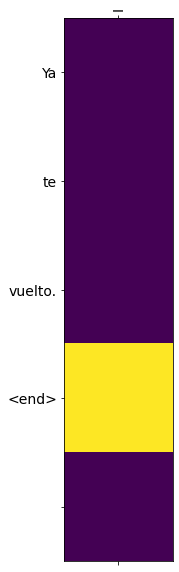

In [36]:
translate('I')